### CIFAR10 veri seti sınıflandırma problemi

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


Load Dataset

In [2]:
def get_data_loader(batch_size=64):
    transform =transforms.Compose([
        transforms.ToTensor(),#görüntüyü tensöre çevir
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))#RGB (renkli görtübüt olduğu için)
        ])
#CIFAR10 veri setini indir 
    train_set= torchvision.datasets.CIFAR10 (root="./data", train=True, download=True, transform=transform)
    test_set= torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
#Data Loader
    train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
    test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)
    
    return train_loader,test_loader


Visualize Dataset

In [3]:
def imshow(img):
    #Verileri normalize etmeden önce gerşi dönüştür
    img= img / 2 + 0.5 #normalize işleminin tersi
    np_img = img.numpy()#tensorden numpy arraye döndür
    plt.imshow(np.transpose(np_img,(1,2,0)))#üç kanal için doğru şekilde sıralama gösterme
    #plt.show()
    

In [4]:
def get_sample_images(train_loader):#veri kümseinden örnek görselleri almak için
    
    data_iter =iter(train_loader)
    images, labels = next(data_iter)
    return images,labels

In [5]:
def visualize(n):
    train_loader, test_loader = get_data_loader()
    
    images ,labels = get_sample_images(train_loader)
    plt.figure()
    for i in range(n):
        plt.subplot(1,n,i+1)
        imshow(images[i])#görseli görselleştir
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()

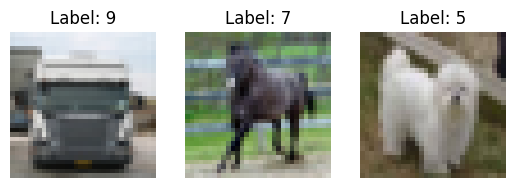

In [6]:
visualize(3)

Build CNN model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN ,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)#in Rgbden 3 out filtre sayısı kernel 3*3matris padding dolgu
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)# 2*2 boyuutnda pooling katmanı
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)#64 filtrel,i ,kn,c, con layer
        self.dropout=nn.Dropout(0.2)#nn d ebulunan hücrelein yüüzd ey,rm,d,s çalışıypor mu çalışmıyor mu
        self.fc1=nn.Linear(in_features=64*8*8,out_features=128)#fully connected layer gririş=4096 
        self.fc2=nn.Linear(in_features=128,out_features=10)
        
    def forward(self, x):
        x=self.pool(self.relu(self.conv1(x)))#ilk convolution layer
        x=self.pool(self.relu(self.conv2(x)))#ikinci convolution layer
        x= x.view(-1, 64*8*8)#flatten
        x=self.dropout(self.relu(self.fc1(x)))#fully connected layer
        x=self.fc2(x)#output
        return x

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=CNN().to(device)

Define Loss and Optimizer

In [9]:
define_loss_and_optimizer=lambda model:(
    nn.CrossEntropyLoss(),
    optim.SGD(model.parameters(),lr=0.001,momentum=0.9)#SGD 
)

Training Model

In [10]:
def train_model(model,train_loader,criterion,optimizer,epochs= 5):
    model.train()#modeli eğitim moduna al
    train_losses=[]#loss değerlerini atmak için bir liste oluyştur
    for epoch in range(epochs):#for döngüsü oluştur epoch sayısı kadar
        total_loss=0#toplam loss değerini saklamka için total_loss tnaımlama
        for images, labels in train_loader:#Tüm eğititm veri setini taramak için for döngüsü
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()#Gradyanları sıfırlamak
            outputs=model(images)#forward pro. prediction
            loss=criterion(outputs, labels)#loss değeri hesapla
            loss.backward()#baclward pro gradyan hespalama
            optimizer.step()#neural networkteki ağılıkları güncelle =öğrenme
            total_loss += loss.item()
        avg_loss=total_loss/len(train_loader)#ortalama kayıp hespalama
        train_losses.append(avg_loss)
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.5f}")
    #Kayıp Loss Graafiği
    plt.figure()
    plt.plot(range(1, epochs+1),train_losses,marker='o',linestyle='-',label='Train Loss')      
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Traininig Loss")
    plt.legend()
    plt.show()

Epoch: 1/10, Loss: 2.03583
Epoch: 2/10, Loss: 1.71659
Epoch: 3/10, Loss: 1.53958
Epoch: 4/10, Loss: 1.42779
Epoch: 5/10, Loss: 1.35287
Epoch: 6/10, Loss: 1.28749
Epoch: 7/10, Loss: 1.23558
Epoch: 8/10, Loss: 1.18548
Epoch: 9/10, Loss: 1.14516
Epoch: 10/10, Loss: 1.10249


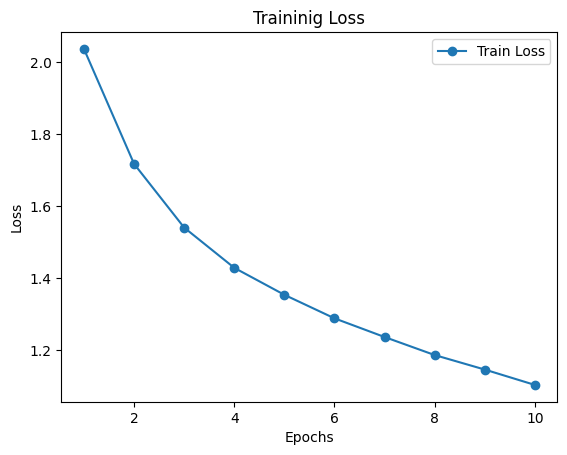

In [11]:
train_loader, test_loader= get_data_loader()
model = CNN().to(device)
criterion, optimizer=define_loss_and_optimizer(model)
train_model(model,train_loader,criterion,optimizer,epochs=10)

Test Model

In [16]:
def test_model(model,test_loader,dataset_type):
    model.eval()#değerlendirme modu
    correct =0 #DOğru thamin syacı
    total=0 #toplam veri sayacı
    with torch.no_grad():#Gradyan hesaplamasını kapat
        for images, labels in test_loader:
            images , labels = images.to(device), labels.to(device)
            
            outputs = model(images) #prediciton
            _, predicted =torch.max(outputs,1)#En yüksek olasılıklı s9ınıfı seç
            total += labels.size(0) #toplam veri sayısıs
            correct += (predicted == labels).sum().item()#Doğru tahminleir say
    print(f"{dataset_type} Accuracy: {100 * correct / total } %")

In [17]:
test_model(model,test_loader, dataset_type= "test")
test_model(model , train_loader, dataset_type= "training")

test Accuracy: 61.17 %
training Accuracy: 64.022 %


Main Program

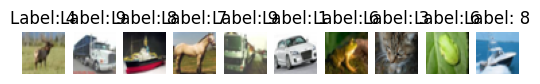

Epoch: 1/1, Loss: 2.09927


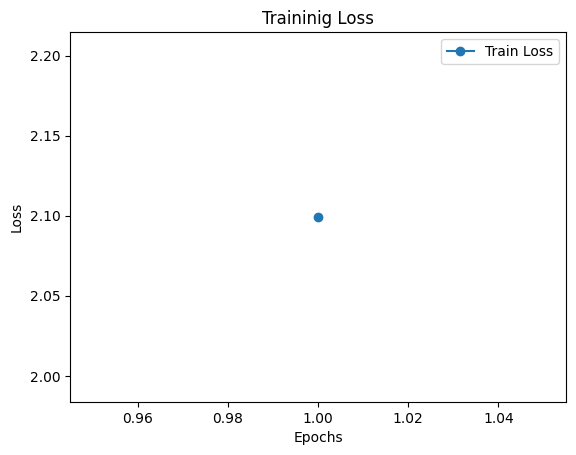

test Accuracy: 35.62 %
training Accuracy: 35.35 %


In [19]:
if __name__== "__main__":
    #Veri seti yükleme
    train_loader,test_loader = get_data_loader()
    #Görselleştirme
    visualize(10)
    #Training
    model=CNN().to(device)
    criterion, optimizer=define_loss_and_optimizer(model)
    train_model(model,train_loader,criterion,optimizer,epochs=10)
    #Test
    test_model(model,test_loader,dataset_type="test")
    test_model(model , train_loader, dataset_type="training")